# Making Maps with Cartopy

**Requirements:** The `conda/analysis3-22.04` (or later) module on the OOD or Gadi (or your own up-to-date cookbook installation).

This tutorial runs through a series of examples that demonstrate how to make maps using data from the COSIMA Cookbook. This tutorial focusses on mapping with `Cartopy`.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cosima_cookbook as cc

We will use the SST field from a 0.25° resolution experiment as our sample data. These maps should work with any 2D data.

In [2]:
session = cc.database.create_session()

experiment = '025deg_jra55v13_iaf_gmredi6'
variable = 'surface_temp'
darray = cc.querying.getvar(experiment, variable, session, frequency='1 monthly', n=-1)
SST = darray.mean('time') - 273.15; # convert from degrees K to degrees C
SST

<xarray.DataArray 'surface_temp' (yt_ocean: 1080, xt_ocean: 1440)>
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95

## Vanilla `.plot()`

You can always make a vanilla plot of this data using `xarray`...

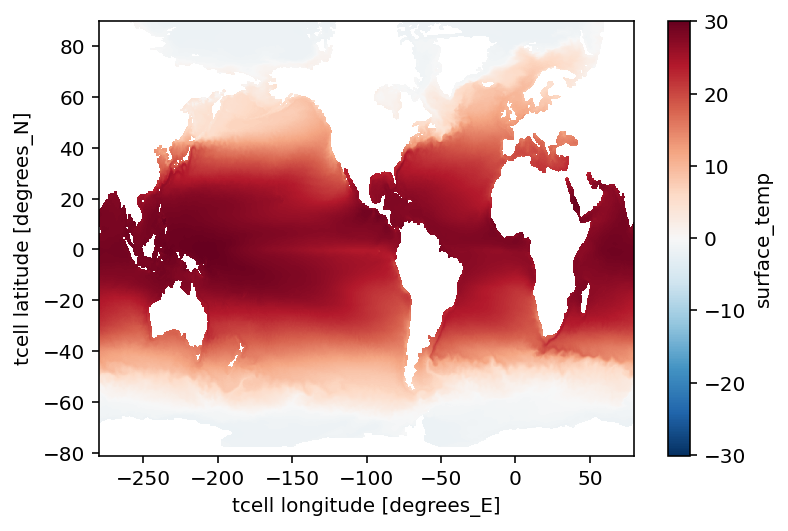

In [3]:
SST.plot();

..., but this doesn't look that appealing. Or, let's just make a subjective remark: it doesn't seem publication-worthy. `:)`

Also, note that there is (objectively) *noticable* distortion in the tripole region, i.e., north of 65°N. (For example, with the current plate-tectonics configuration, Canada does not touches the North Pole as the figure might imply.)

## Using Cartopy
Instead, let's plot the same data with cartopy. This example uses the `Robinson` global projection -- but note that key argument in the plot function: `transform=ccrs.PlateCarree()` -- which is needed every time you plot something with cartopy. (Confusingly, you could also use a `PlateCarree` projection, not to be confused with the transformation ...)

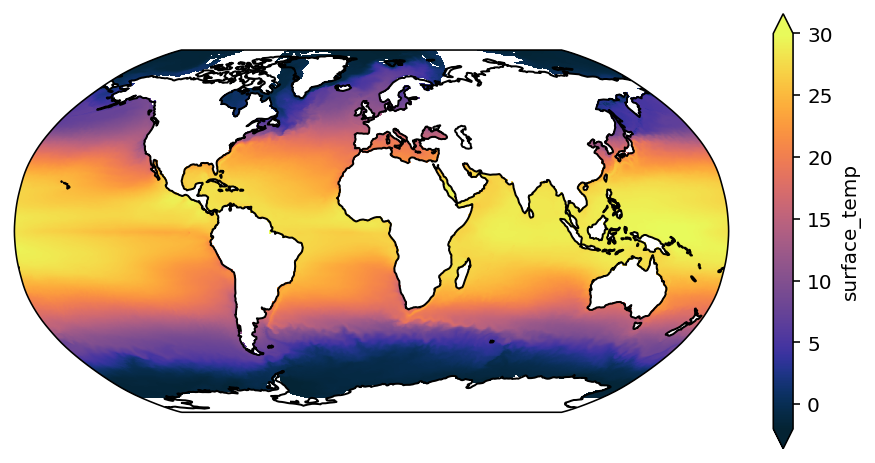

In [4]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())

SST.plot(ax=ax,
         x='xt_ocean', y='yt_ocean', 
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal)

ax.coastlines();

You can see that this looks a little better. 

## Colouring in the land
Say, for example, we don't like such a huge colorbar. Also, say we'd prefer the land colour to be something other than white. These details can be dealt with by doing something like the following.

Let's first colour the land.

In [5]:
import cartopy.feature as cft

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

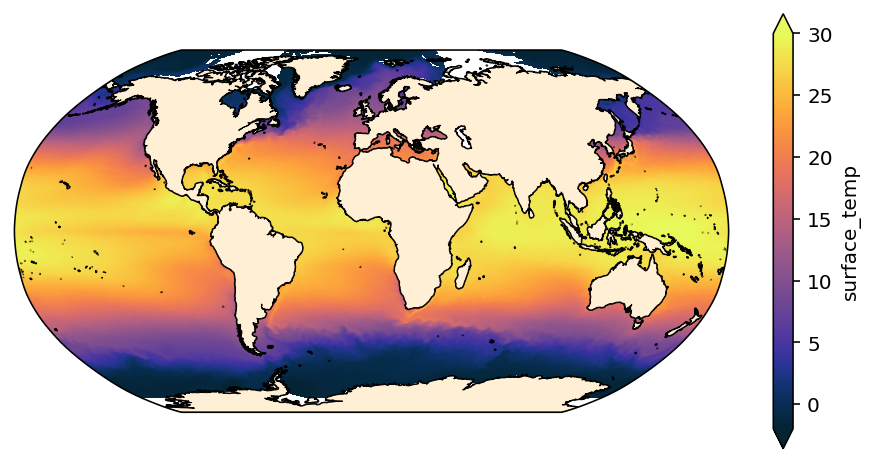

In [6]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())

SST.plot.pcolormesh(ax=ax,
                    x='xt_ocean', y='yt_ocean',
                    transform=ccrs.PlateCarree(),
                    vmin=-2, vmax=30, extend='both',
                    cmap=cm.cm.thermal)

ax.coastlines(resolution='50m')
ax.add_feature(land_50m);

However, there is still a glitch in this plot -- because data in the tripole region is distorted. This occurs because the 1D coordinates `xt_ocean` and `yt_ocean` are actually incorrect in the tripole region. 

## Fixing the tripole
Instead, we need to plot with the 2D arrays of x and y locations -- `geolon_t` and `geolat_t` which we save as static data from each run.

We load `geolon_t` and `geolat_t` and assign these 2D-arrays as coordinates on our data array.

In [7]:
geolon_t = cc.querying.getvar(experiment, 'geolon_t', session, n=-1)
geolat_t = cc.querying.getvar(experiment, 'geolat_t', session, n=-1)

SST = SST.assign_coords({'geolon_t': geolon_t, 'geolat_t': geolat_t})
SST

<xarray.DataArray 'surface_temp' (yt_ocean: 1080, xt_ocean: 1440)>
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(540, 720), meta=np.ndarray>

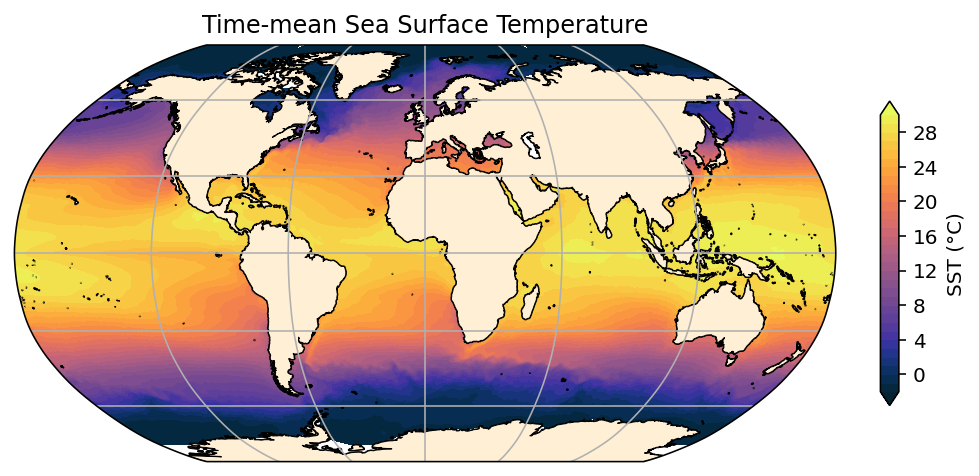

In [8]:
fig = plt.figure(figsize=(8, 4))

ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='50m')
ax.add_feature(land_50m)

gl = ax.gridlines(draw_labels=False)

SST.plot.contourf(ax=ax,
                  x='geolon_t', y='geolat_t',
                  levels=33, vmin=-2, vmax=30,
                  extend='both',
                  cmap=cm.cm.thermal,
                  transform=ccrs.PlateCarree(),
                  cbar_kwargs = {'label': 'SST (°C)',
                                 'fraction': 0.03,
                                 'aspect': 15,
                                 'shrink': 0.7})

plt.title('Time-mean Sea Surface Temperature');

OK, so that's a bit better. We also tweaked the colorbar using `cbar_kwargs`.

But you may have noticed that we had to use `contourf` to make this map: we can't use just `.plot` (which fallsback to `pcolormesh`) in this instance, because `geolon_t` and `geolat_t` we loaded via, e.g.,
```python
cc.querying.getvar(experiment, 'geolat_t', session, n=-1)
```
are masked arrays and `pcolormesh` can't cope with underfined coordinates.  (To convince yourself try out `SST.plot(x='geolon_t', y='geolat_t')`.) Our options here are:

- Try contourf instead - it should work;
- Use `pcolor`, noting that this is sometimes very slow;
- Read in the 2D longitude/latitude coordinates from a file that we prepared earlier ...

So to demonstrate the last option here we first drop the masked coordinates drom our data array:

In [9]:
SST = SST.drop({'geolon_t', 'geolat_t'})
SST

<xarray.DataArray 'surface_temp' (yt_ocean: 1080, xt_ocean: 1440)>
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95

And then load the unmasked ones.

In [10]:
# these lon/lat arrays are NOT masked
geolon_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolon_t
geolat_t = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc').geolat_t

SST = SST.assign_coords({'geolat_t': geolat_t, 'geolon_t': geolon_t})
SST

<xarray.DataArray 'surface_temp' (yt_ocean: 1080, xt_ocean: 1440)>
dask.array<sub, shape=(1080, 1440), dtype=float32, chunksize=(540, 720), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
    geolon_t  (yt_ocean, xt_ocean) float32 -279.9 -279.6 -279.4 ... 80.0 80.0
    geolat_t  (yt_ocean, xt_ocean) float32 -81.08 -81.08 -81.08 ... 65.13 65.03

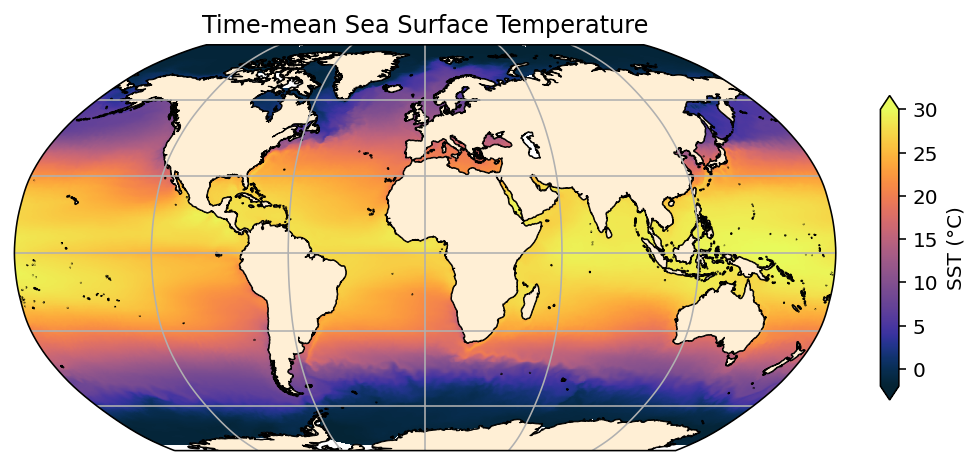

In [11]:
plt.figure(figsize=(8, 4))
ax = plt.axes(projection=ccrs.Robinson())

ax.coastlines(resolution='50m')
ax.add_feature(land_50m)
ax.gridlines(draw_labels=False)
                
SST.plot(ax=ax,
         x='geolon_t', y='geolat_t',
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal,
         cbar_kwargs = {'label': 'SST (°C)',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7})

plt.title('Time-mean Sea Surface Temperature');

This is about as good as we can get. Note that there are some mismatches between the coastlines in the model and reality, principally around Antarctica and the Canadian Archipelago. Also, note that the `ocean_grid_025.nc` file used here will only work for 0.25° resolution cases - check to see if others are available.

## Subplots

It can be a bit tricky to use Cartopy with subplots. Here's an example:

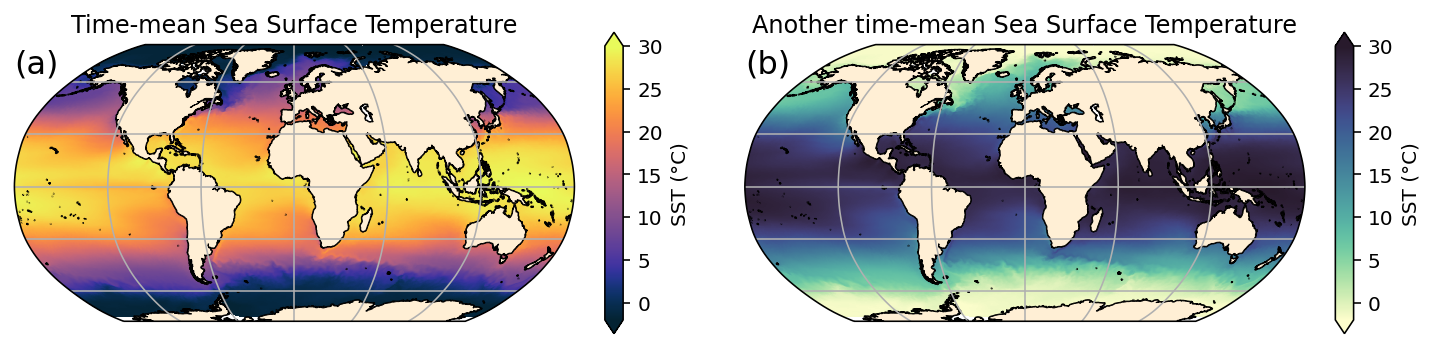

In [12]:
fig, axes = plt.subplots(ncols = 2, subplot_kw={'projection': ccrs.Robinson()}, figsize = (12, 8))

cbar_kwargs = {'label': 'SST (°C)',
               'fraction': 0.03,
               'aspect': 15,
               'shrink': 0.7}

SST.plot(ax=axes[0],
         x='geolon_t', y='geolat_t',
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal,
         cbar_kwargs=cbar_kwargs)

SST.plot(ax=axes[1],
         x='geolon_t', y='geolat_t',
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.deep,
         cbar_kwargs=cbar_kwargs)

import string

# add features and label panels
for n, ax in enumerate(axes):
    # features
    ax.coastlines(resolution='50m')
    ax.add_feature(land_50m)
    ax.gridlines(draw_labels=False)
    
    # subplot labels
    ax.text(0, 0.9, '('+string.ascii_lowercase[n]+')', transform=ax.transAxes, size=16)

axes[0].set_title('Time-mean Sea Surface Temperature')
axes[1].set_title('Another time-mean Sea Surface Temperature');

## Projections
Here are a few interesting projections you can use with `cartopy` that might be useful for other applications. Note that if you decide to use a map region which extends north of 65°N, you should use the 2D coordinte files as per above.

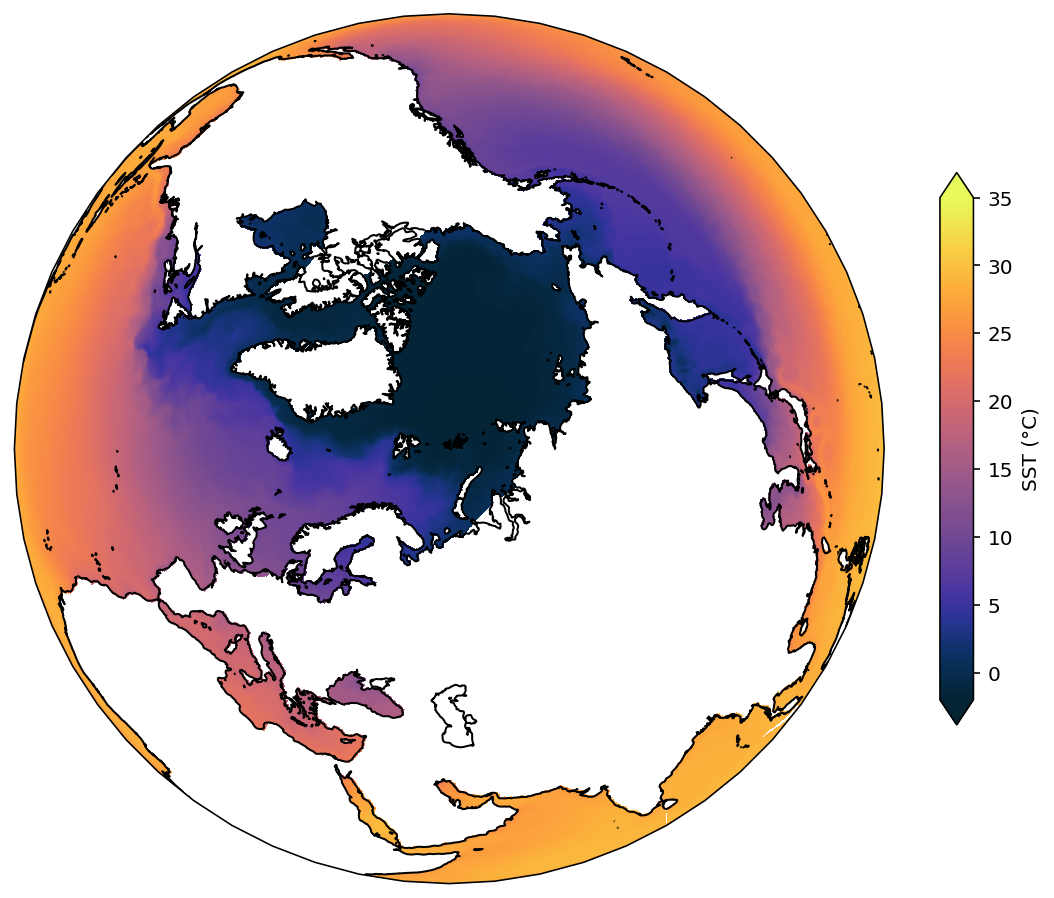

In [13]:
projection = ccrs.Orthographic(central_latitude=80, central_longitude=50)

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=projection)

ax.coastlines(resolution='50m');

SST.plot(x='geolon_t', y='geolat_t',
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=35, extend='both',
         cmap=cm.cm.thermal,
         cbar_kwargs = {'label': 'SST (°C)',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});

### Near Sided Perspective

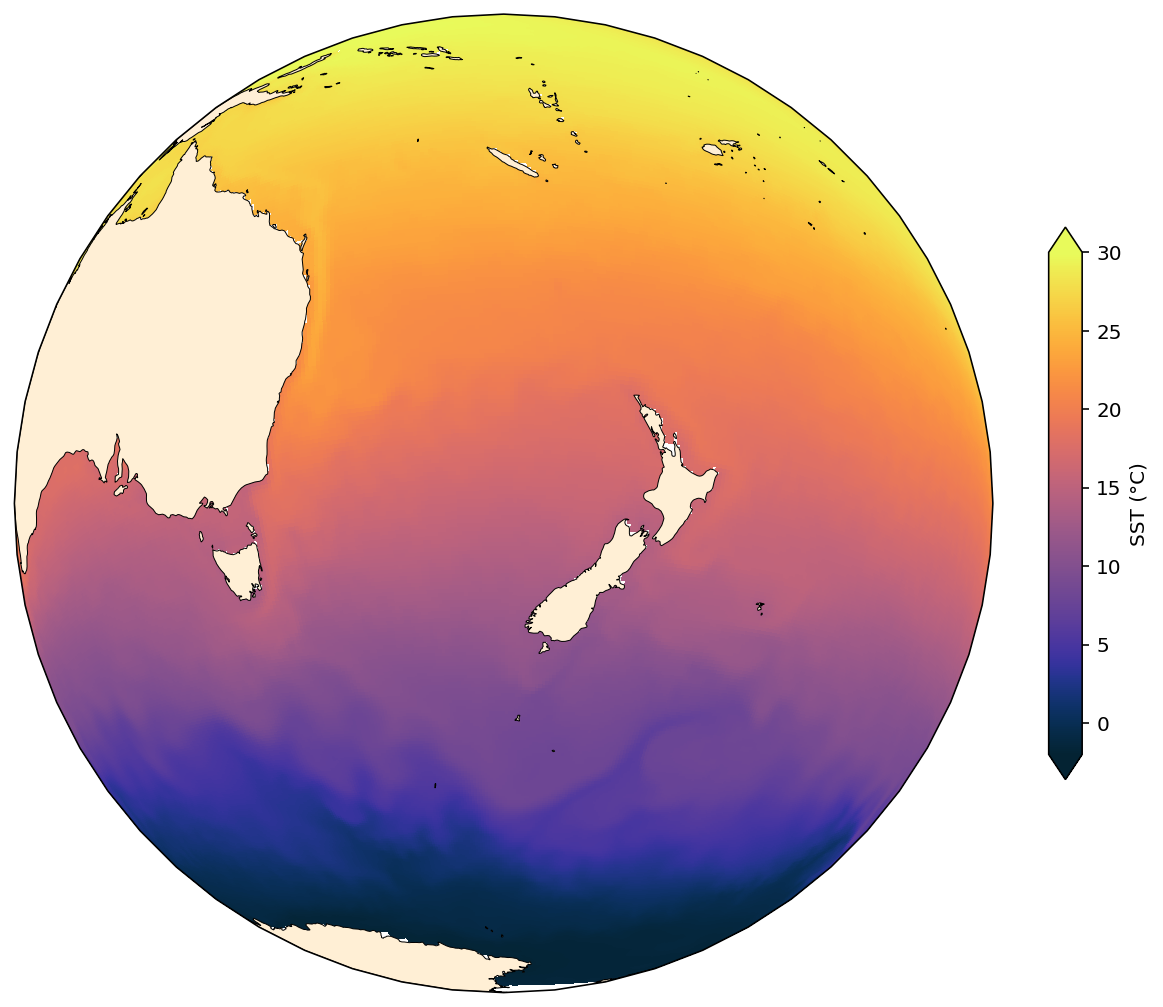

In [14]:
projection = ccrs.NearsidePerspective(central_longitude=165.0, central_latitude=-40.0, satellite_height=2500000)

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)

SST.plot(x='geolon_t', y='geolat_t',
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal,
         cbar_kwargs = {'label': 'SST (°C)',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});

### South Polar Stereo
Note that this plot, by default, shows the entire globe, which undermines the area of the South Pole region. So, to enhance our beloved Southern Ocean we have to cut an area of the figure to focus down on it. 

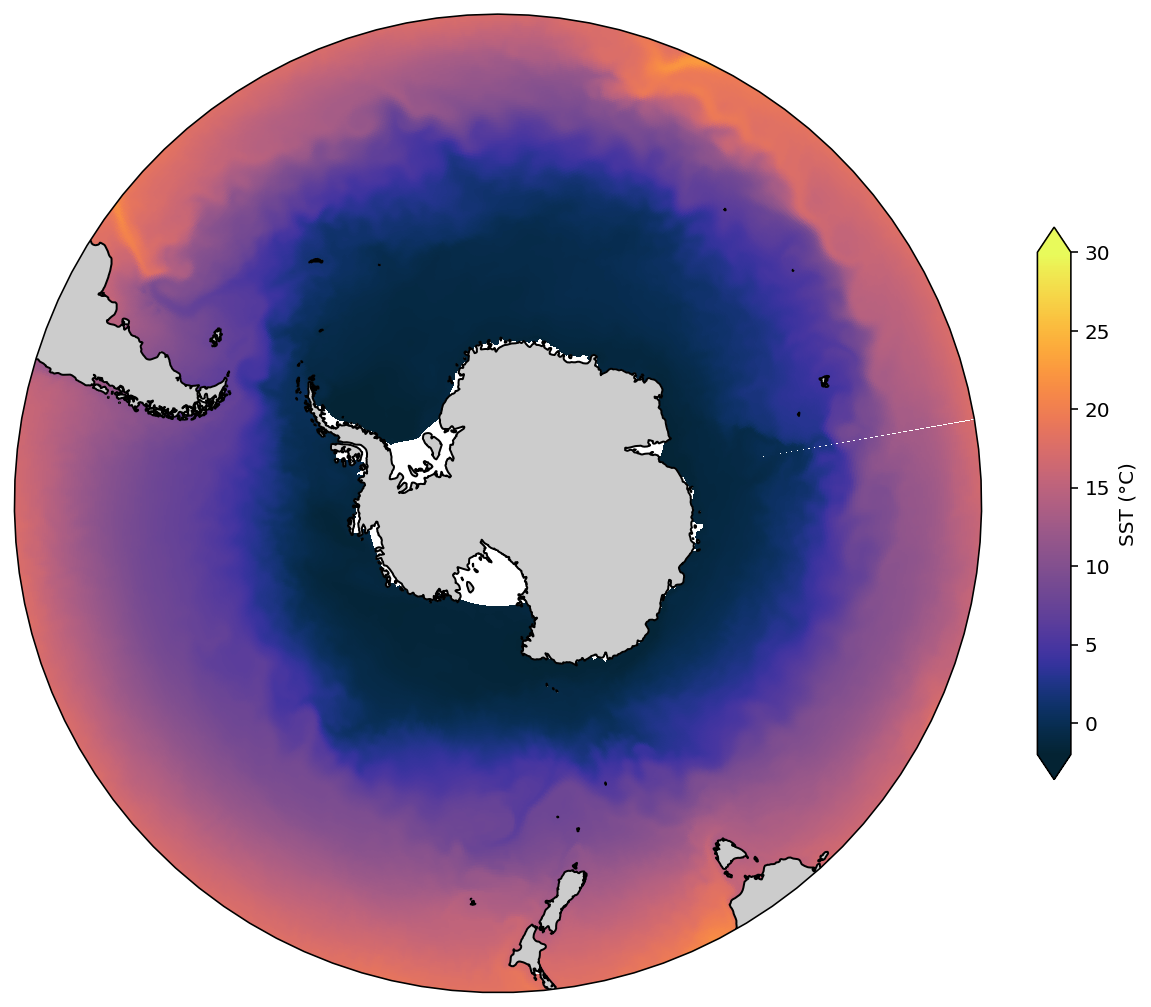

In [15]:
projection = ccrs.SouthPolarStereo()

plt.figure(figsize=(10, 9))
ax = plt.axes(projection=projection)

ax.set_extent([-280, 80, -80, -35], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.

import matplotlib.path as mpath

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

SST.plot(x='geolon_t', y='geolat_t',
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal,
         cbar_kwargs = {'label': 'SST (°C)',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});

### Mercator regional plot

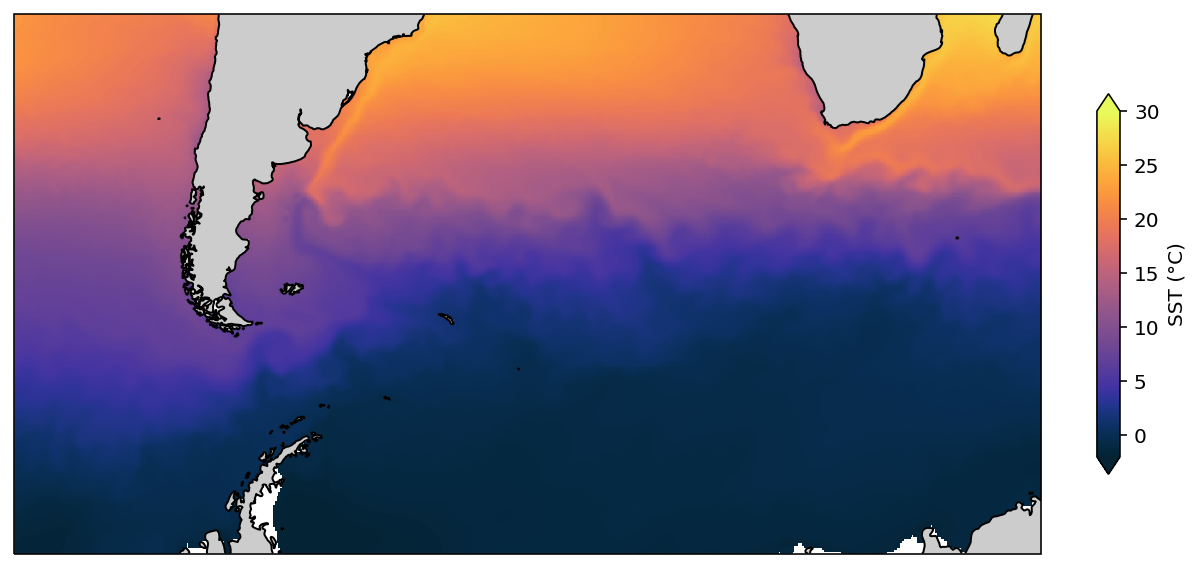

In [16]:
projection = ccrs.Mercator(central_longitude=0.0, min_latitude=-70.0, max_latitude=-20.0)

plt.figure(figsize=(10, 5))
ax = plt.axes(projection=projection)

ax.set_extent([-100, 50, -70, -20], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')

SST.plot(x='geolon_t', y='geolat_t',
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal,
         cbar_kwargs = {'label': 'SST (°C)',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});

### Sector map

This map shows a sector of the Southern Ocean. It involves a Stereographic projection and a fairly complicated cutout to set the boundary of the map, but gives a nice result.

In [17]:
def make_boundary_path(longitudes, latitudes):
    """
    Returns a path around boundary to create a sector map, then cut it out given
    longitudes and latitudes.
    """
    boundary_path = np.array([longitudes[-1, :], latitudes[-1, :]])
    boundary_path = np.append(boundary_path, np.array([longitudes[::-1, -1], latitudes[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[1, ::-1],  latitudes[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([longitudes[:, 1],     latitudes[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))

    return boundary_path

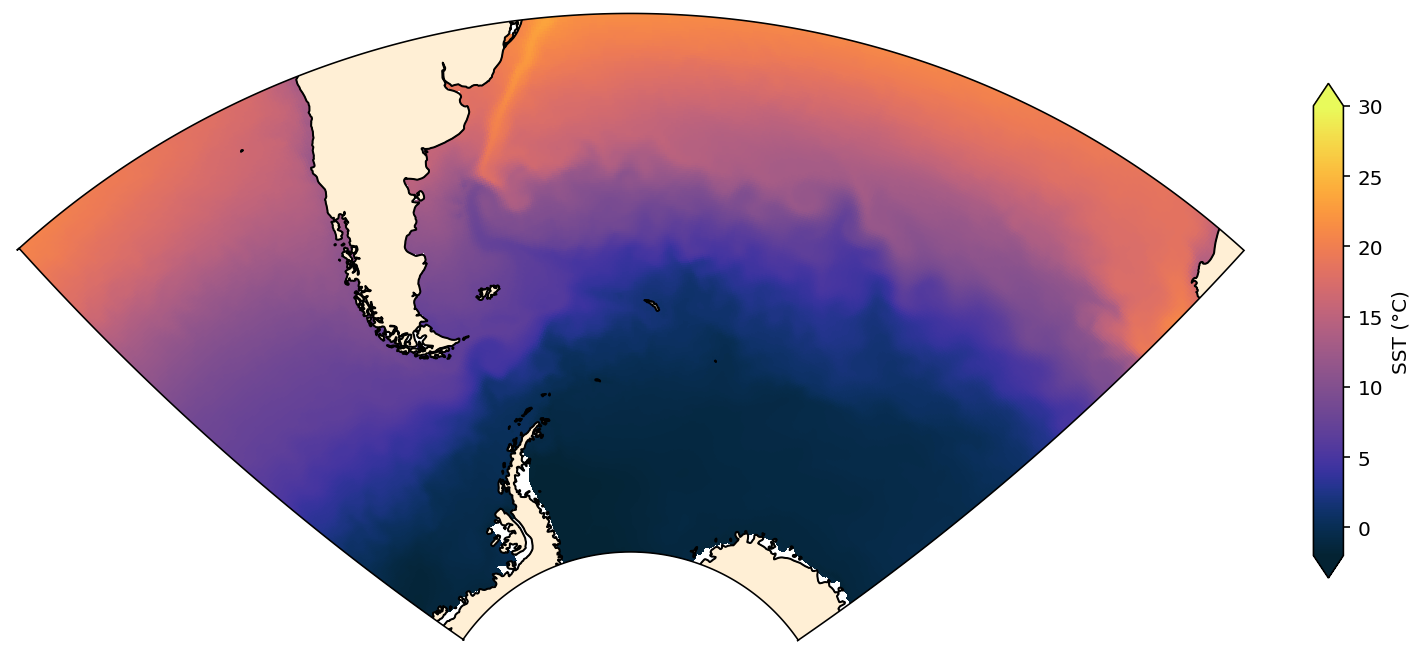

In [18]:
midlon = -40
maxlon = midlon + 60
minlon = midlon - 60
minlat = -75
maxlat = -30
midlat = (minlat + maxlat)/2

projection=ccrs.Stereographic(central_longitude=midlon, central_latitude=midlat)

fig = plt.figure(figsize=(12, 6.5))
ax = plt.axes(projection=projection)

ax.add_feature(land_50m)
ax.coastlines(resolution='50m')
ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

lons = geolon_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
lats = geolat_t.sel({'xt_ocean': slice(minlon, maxlon), 'yt_ocean': slice(minlat, maxlat)})
boundary_path = make_boundary_path(lons, lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())

SST.plot(x='geolon_t', y='geolat_t',
         transform=ccrs.PlateCarree(),
         vmin=-2, vmax=30, extend='both',
         cmap=cm.cm.thermal,
         cbar_kwargs = {'label': 'SST (°C)',
                        'fraction': 0.03,
                        'aspect': 15,
                        'shrink': 0.7});

You can see a wider selection of `cartopy` projections in its documentation: https://scitools.org.uk/cartopy/docs/latest